In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kag}gle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
# library imports
import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
# neural network wizardry
import tensorflow as tf
from os.path import join
import glob
# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# paths
img_train_folder = Path('/kaggle/input/train_images/')
img_test_folder = Path('/kaggle/input/test_images/')

from imblearn.over_sampling import RandomOverSampler

In [19]:
DATA_DIR = join('..', 'input/severstal-steel-defect-detection')

TRAIN_IMG_DIR = join(DATA_DIR, 'train_images')
TEST_IMG_DIR = join(DATA_DIR, 'test_images')
SAMPLE_SUB = join(DATA_DIR, 'sample_submission.csv')
TRAIN_DATA = join(DATA_DIR, 'train.csv')
model_save_path = join('.', 'ResUNetSteel_z.h5')
pretrained_model_path = join('..', 'input', 'severstal-pretrained-model', 'ResUNetSteel_z.h5')

train_df = pd.read_csv(TRAIN_DATA)
x=train_df.drop("EncodedPixels",axis=1)
y=train_df['ClassId']
x,y=RandomOverSampler(sampling_strategy='minority').fit_resample(x,y)

train_df['ImageId_ClassId'] = train_df.apply(lambda x: '{}_{}'.format(x.ImageId, x.ClassId), axis=1)
sub_df = pd.read_csv(SAMPLE_SUB)
save_model = True

# Kernel Configurations
make_submission = False # used to turn off lengthy model analysis so a submission version doesn't run into memory error
load_pretrained_model = True # load a pre-trained model

In [3]:
train_df = pd.read_csv(TRAIN_DATA)
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
x.shape,y.shape

((11998, 2), (11998,))

In [6]:
pd.Series(y).value_counts()

3    5150
2    5150
1     897
4     801
Name: ClassId, dtype: int64

In [7]:
train_df['ClassId'].value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [8]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [20]:
def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indices where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [21]:
def rle_to_mask(lre, shape=(1600, 256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape).T

In [22]:
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import cv2
from sklearn.model_selection import train_test_split

In [23]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 512 # resized weidth
img_h = 128 # resized height
batch_size = 8
epochs = 20
# batch size for training unet
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair

# ** oversampling **

repeat = False
# only valid if repeat is True
class_1_repeat = 1 # repeat class 1 examples x times
class_2_repeat = 1
class_3_repeat = 1
class_4_repeat = 1

In [24]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
      
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
#             image_resized -= image_resized.mean()
#             image_resized /= image_resized.std()
            image_resized = image_resized.astype('float') / 255.
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, (1600, 256))
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[..., idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2) #gray scale rep
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(int)
            
        return X, y

In [25]:
# create a dict of all the masks
masks = {}
for index, row in train_df.iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [12]:
# x=rle_to_mask(masks['0002cc93b.jpg_1'])
# x=(x>0).astype(int)
# x

In [26]:
# repeat low represented samples more frequently to balance our dataset
if repeat:
    class_1_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='1')]['ImageId'].values
    class_1_img_id = np.repeat(class_1_img_id, class_1_repeat)
    class_2_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='2')]['ImageId'].values
    class_2_img_id = np.repeat(class_2_img_id, class_2_repeat)
    class_3_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='3')]['ImageId'].values
    class_3_img_id = np.repeat(class_3_img_id, class_3_repeat)
    class_4_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='4')]['ImageId'].values
    class_4_img_id = np.repeat(class_4_img_id, class_4_repeat)
    train_image_ids = np.concatenate([class_1_img_id, class_2_img_id, class_3_img_id, class_4_img_id])
else:
    # split the training data into train and validation set (stratified)
    train_image_ids = train_df['ImageId'].unique()

In [28]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [29]:
X_train

array(['dcf78e7eb.jpg', 'b0348d794.jpg', '04c3aade7.jpg', ...,
       'c802d3e11.jpg', 'cdf669a1f.jpg', '209e34a89.jpg'], dtype=object)

In [30]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': TRAIN_IMG_DIR,
          'batch_size': batch_size,
          'shuffle': True}

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [31]:
# check out the shapes
x, y = training_generator.__getitem__(1)
print(x.shape, y.shape)

(8, 128, 512, 1) (8, 128, 512, 4)


In [32]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Oranges", "Blues", "Purples", "Reds"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.2, cmap=cmaps[idx])

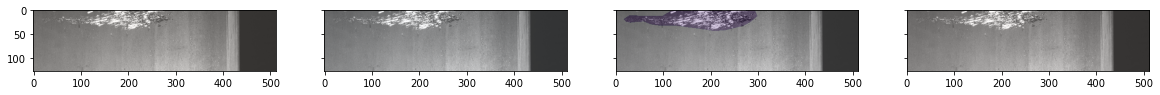

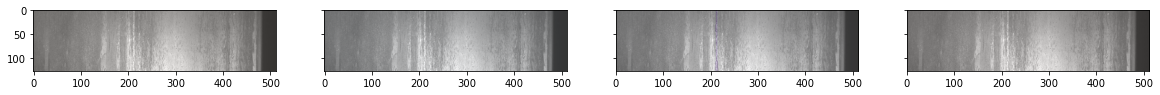

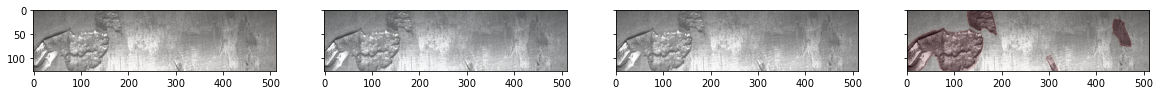

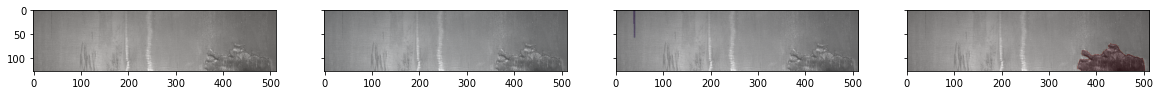

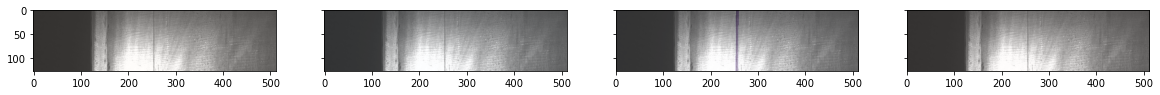

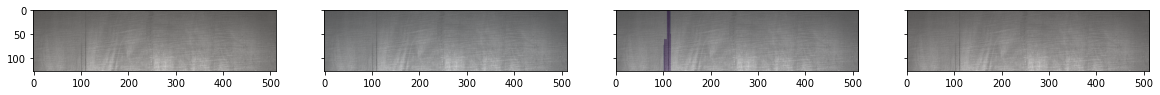

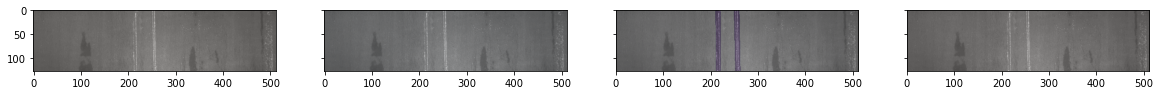

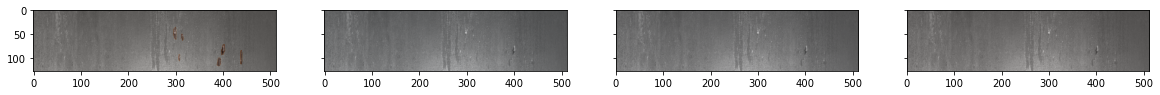

In [33]:
x, y = training_generator[np.random.randint(len(training_generator))]
for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        img = x[ix]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_steel_img_mask(img, masks_temp)

In [34]:
x[1].shape

(128, 512, 1)

In [35]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

In [22]:
# def mask_to_contours(image, mask_layer, color):
#     """ converts a mask to contours using OpenCV and draws it on the image
#     """
#     mask_layer = np.array(mask_layer, dtype=np.uint8)
#     # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
#     contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#     image = cv.drawContours(image, contours, -1, color, 1)
#     return image

In [23]:
# def mask_to_contours(image, mask_layer, color):
#     """ converts a mask to contours using OpenCV and draws it on the image
#     """
#     mask_layer = np.array(mask_layer, dtype=np.uint8)
#     # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
#     contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#     image_with_contours = cv.drawContours(image.copy(), contours, -1, color, 2)
#     image = cv2.addWeighted(image, 0.5, image_with_contours, 0.5, 0.0)
        
#     return image

In [36]:
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(0,4))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))
colors

['rgb(141,211,199)',
 'rgb(255,255,179)',
 'rgb(190,186,218)',
 'rgb(251,128,114)']

In [37]:


def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """
    mask_layer = np.array(mask_layer, dtype=np.uint8)
    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#     if color==0:
#         color_rgb=(141,211,199,)
#     elif color==1:
#         color_rgb=(255,255,179,)
#     elif color==2:
#         color_rgb=(190,186,218,)
#     else:
#         color_rgb=(251,128,114,)
        
    image = cv.drawContours(image, contours, -1,color, 1)
    return image

def visualize_mask(x, mask):
    fig, ax = plt.subplots(nrows=batch_size, figsize=(15, 15*3))
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    for ix in range(0, batch_size):
        image = x[ix]
        image= cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2RGB)
        for index in range(mask.shape[-1]):
            image = mask_to_contours(image, mask[ix][...,index],color=colors[index])
        ax[ix].imshow(image)
        
#  def visualize_mask(x,mask):
#     fig,ax=plt.subplots(nrows=batch_size,ncols=1,figsize=(20,15))
#     cmaps = ["Oranges", "Blues", "Purples", "Reds"]
#     for ix in range(0,batch_size):
#         image=x[ix].astype('int32')
#         for index in range(mask.shape[-1]):
#             image=mask_to_contours(image, mask[ix][...,index],color=ix)  
#         ax[ix].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))

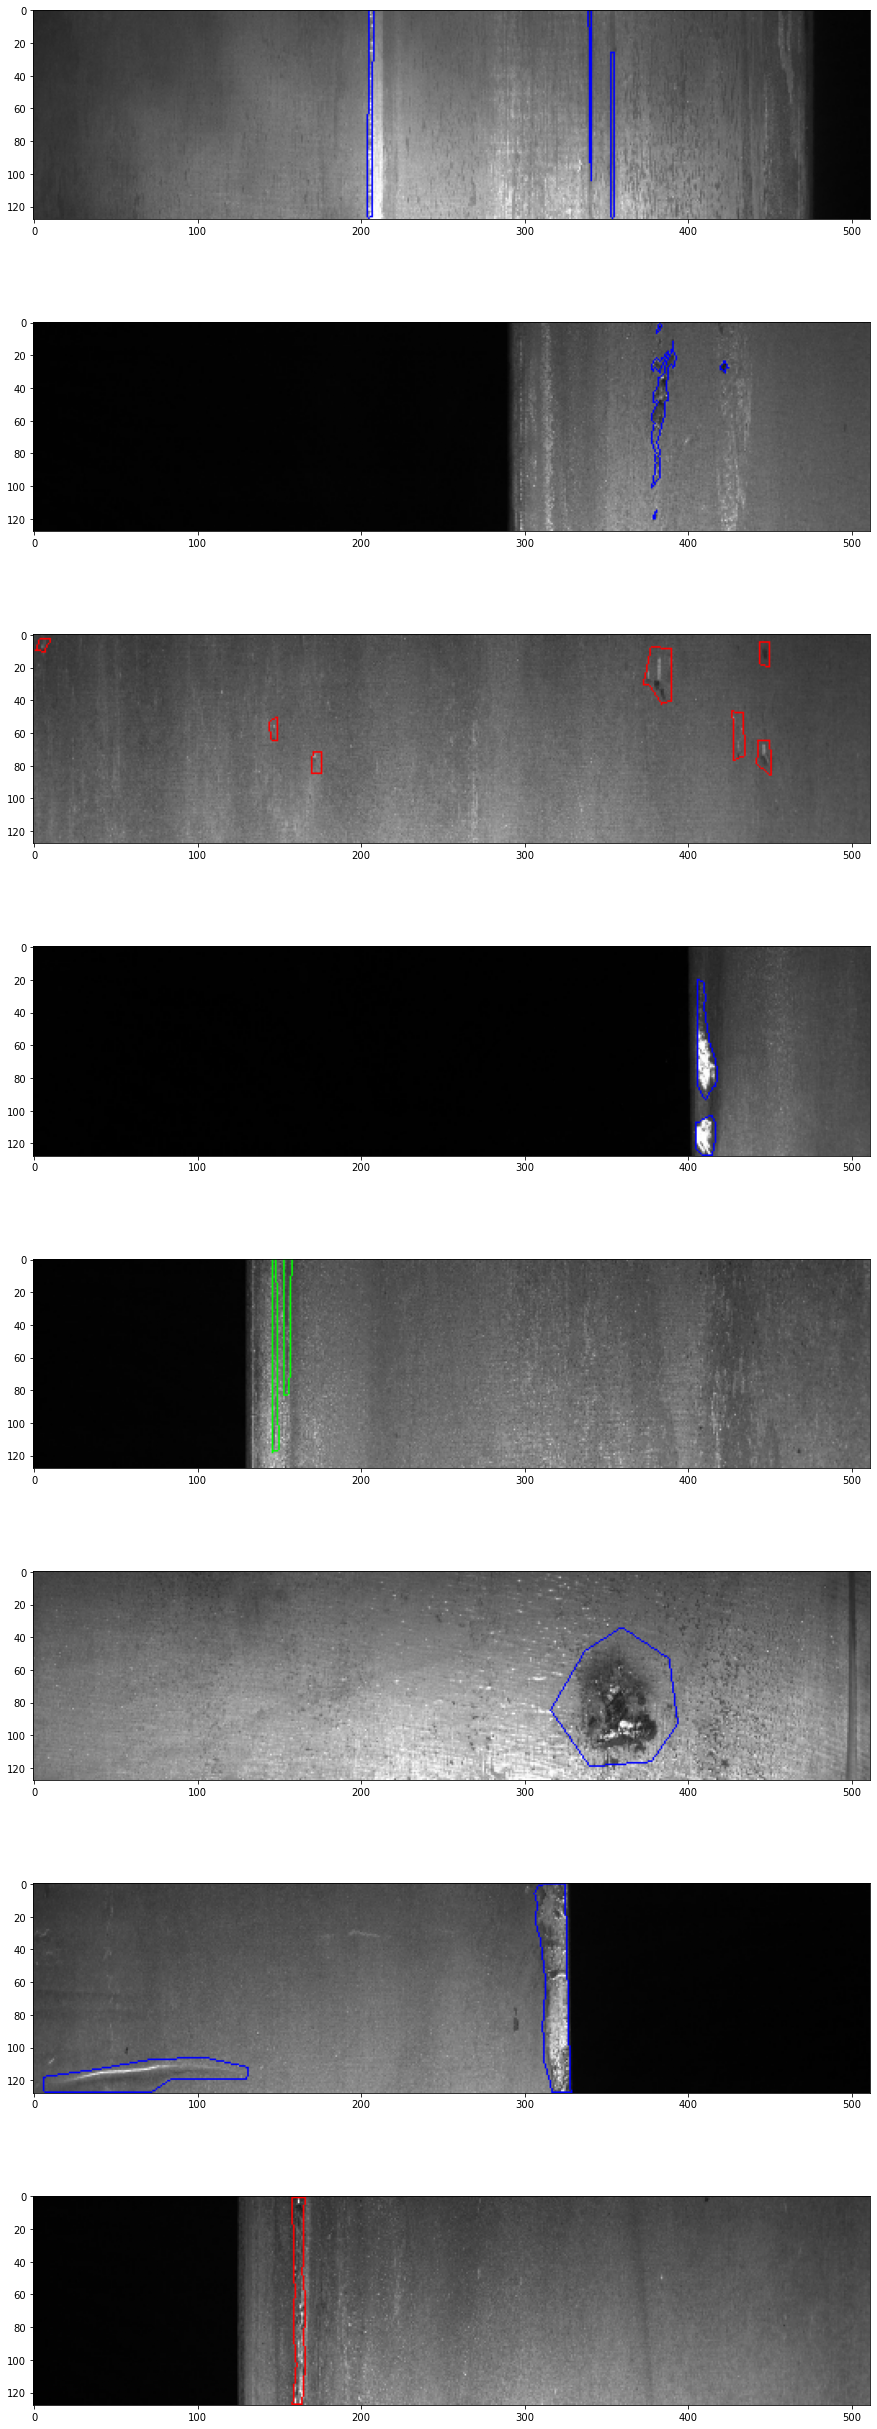

In [38]:
x, y = training_generator[np.random.randint(len(training_generator))]
visualize_mask(x,y)

In [39]:
res_50='https://tfhub.dev/google/circularnet_3/1'

In [40]:
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime

In [41]:
def create_tensorboard_callbacks(dir_name, experiment_name):
    log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir)
    print(f"TensorBoard is saving on directory:{log_dir}")
    return tensorboard_callbackswe

In [42]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,UpSampling2D,Concatenate,Add,Flatten
from tensorflow.keras.losses import binary_crossentropy

def bn_act(x,act=True):
	x=tf.keras.layers.BatchNormalization()(x)
	if act==True:x=tf.keras.layers.Activation('relu')(x)
	return x

def conv_block(x,filters,kernel_size=3,padding='same',strides=1):
	conv=bn_act(x)
	conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(conv)
	return conv

def stem(x,filters,kernel_size=3,padding='same',strides=1):
	conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(x)
	conv=conv_block(conv,filters,kernel_size,padding,strides)
	shortcut=Conv2D(filters,kernel_size=1,padding=padding,strides=strides)(x)
	shortcut=bn_act(shortcut,act=False)
	output=Add()([conv,shortcut])
	return output

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x,xskip):
	u=UpSampling2D((2,2))(x)
	c=Concatenate()([u,xskip])
	return c

In [43]:
def ResUNet(img_h,img_w):
	f=[16,32,64,128,256]
	inputs=Input((img_h,img_w,1))

	e0=inputs
	e1=stem(e0,f[0])
	e2=residual_block(e1,f[1],strides=2)
	e3=residual_block(e2,f[2],strides=2)
	e4=residual_block(e3,f[3],strides=2)
	e5=residual_block(e4,f[4],strides=2)

	b0=conv_block(e5,f[4],strides=1)
	b1=conv_block(b0,f[4],strides=1)

	u1=upsample_concat_block(b1,e4)
	d1=residual_block(u1,f[4])

	u2=upsample_concat_block(d1,e3)
	d2=residual_block(u2,f[3])

	u3=upsample_concat_block(d2,e2)
	d3=residual_block(u3,f[2])

	u4=upsample_concat_block(d3,e1)
	d4=residual_block(u4,f[1])

	outputs=tf.keras.layers.Conv2D(4,(1,1),padding='same',activation='sigmoid')(d4)
	model=tf.keras.models.Model(inputs,outputs)
	return model


In [44]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [45]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[dice_loss])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=30, verbose=1)

Epoch 1/30
126/666 [====>.........................] - ETA: 2:18 - loss: 0.8683 - dice_loss: 0.8798

In [ ]:
fig,ax=plt.subplots(2,1)
ax[0].plot(history.history.get('loss'),'r')
ax[0].plot(history.history.get('val_loss'),'g')


In [ ]:
x,y=validation_generator.__getitem__(1)

In [ ]:
x.shape,y.shape

In [ ]:
y_pred=model.predict(np.expand_dims(x[0],axis=0))

In [ ]:
y_pred.shape

In [ ]:
y_pred=(y_pred >= 0.5).astype(int)



In [ ]:
y_pred.shape

In [ ]:
def visualize_mask_1(x, mask):
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    plt.figure(figsize=(10,10))
    image = x
    image= cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2RGB)
    for index in range(mask.shape[-1]):
        image = mask_to_contours(image, mask[0][...,index],color=colors[index])
    plt.imshow(image)

In [ ]:
visualize_mask_1(x[0],y_pred)

In [ ]:
visualize_mask_1(x[0],y)

In [ ]:
visualize_mask_1(x[0],y_pred) 